In [37]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import f_oneway
from scipy.stats import skew, kurtosis
from skimage.util import img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from collections import Counter
import openpyxl

In [38]:
def collect_data(path_to_gen_folder):
    images = dict()
    labels = dict()
    for folder_name in os.listdir(path_to_gen_folder):
        if not(folder_name.isdigit()):
            continue
        class_path = os.path.join(path_to_gen_folder, folder_name)
        images[folder_name] = []
        labels[folder_name] = []

        if os.path.isdir(class_path):
            print(f"Загружаю данные из папки:{folder_name}")
            for filename in os.listdir(class_path):
                if filename.lower().endswith('.jpg'):
                    file_path = os.path.join(class_path, filename)
                    labels[folder_name].append(file_path)
                    image = cv2.imread(file_path)
                    if image is not None:
                        images[folder_name].append(image)
        print(f"Загрузка из папки:{folder_name} закончена")
    return images, labels



In [39]:
image_dict, labels = collect_data("Metrology-Meter-AI-CV-MIPT-AUT-2025")

Загружаю данные из папки:110
Загрузка из папки:110 закончена
Загружаю данные из папки:130
Загрузка из папки:130 закончена
Загружаю данные из папки:150
Загрузка из папки:150 закончена
Загружаю данные из папки:170
Загрузка из папки:170 закончена
Загружаю данные из папки:190
Загрузка из папки:190 закончена
Загружаю данные из папки:210
Загрузка из папки:210 закончена
Загружаю данные из папки:230
Загрузка из папки:230 закончена
Загружаю данные из папки:250
Загрузка из папки:250 закончена
Загружаю данные из папки:50
Загрузка из папки:50 закончена
Загружаю данные из папки:70
Загрузка из папки:70 закончена
Загружаю данные из папки:90
Загрузка из папки:90 закончена


In [40]:
gray_images_dict = dict()
for distance in image_dict:
    gray_images_dict[distance] = []
    j = image_dict[distance]
    for i in range(len(j)):
        gray_images_dict[distance].append(cv2.cvtColor(j[i], cv2.COLOR_BGR2GRAY))

In [41]:
def calculate_basic_stats(gray_image):
    image_float = gray_image.astype(np.float32) / 255.0 # нормировка
    
    return {
        'brightness_mean': np.mean(image_float),
        'brightness_std': np.std(image_float),
        'brightness_skew': skew(image_float.flatten()),
        'brightness_kurtosis': kurtosis(image_float.flatten()),
        'brightness_median': np.median(image_float)
    }

In [42]:
def calculate_glcm_features(gray_image, distances=[1, 3, 5], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    image_uint8 = img_as_ubyte(gray_image)
    
    glcm = graycomatrix(
        image_uint8, 
        distances=distances, 
        angles=angles,
        levels=256,
        symmetric=True, 
        normed=True
    )
    
    features = {}
    properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM']
    
    for prop in properties:
        prop_values = graycoprops(glcm, prop)
        features[f'{prop}_mean'] = np.mean(prop_values)
        features[f'{prop}_std'] = np.std(prop_values)
    
    return features

In [43]:
def calculate_entropy(gray_image):
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist)) # по определению энтропии по Шеннону

In [44]:
def create_features_vectorized(gray_images_dict):
    """Создает многомерные векторы признаков из изображений"""
    all_feature_vectors = []
    all_targets = []
    
    for class_name, gray_images_list in gray_images_dict.items():
        print(f"Обрабатываю класс: {class_name}")
        
        for i, gray_image in enumerate(gray_images_list):
            feature_vector = []
            
            # 1. Базовые статистики (5 признаков)
            basic_stats = calculate_basic_stats(gray_image)
            feature_vector.extend([
                basic_stats['brightness_mean'],
                basic_stats['brightness_std'],
                basic_stats['brightness_skew'],
                basic_stats['brightness_kurtosis'],
                basic_stats['brightness_median']
            ])
            
            # 2. GLCM признаки (12 признаков)
            glcm_features = calculate_glcm_features(gray_image)
            glcm_properties = ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM']
            for prop in glcm_properties:
                feature_vector.append(glcm_features[f'{prop}_mean'])
                feature_vector.append(glcm_features[f'{prop}_std'])
            
            # 3. Энтропия (1 признак)
            feature_vector.append(calculate_entropy(gray_image))

            all_feature_vectors.append(feature_vector)
            all_targets.append(int(class_name))
    
    # Преобразуем в numpy массивы
    X = np.array(all_feature_vectors)
    y = np.array(all_targets)
    
    print(f"Создан массив признаков: {X.shape}")
    print(f"Количество образцов: {X.shape[0]}")
    print(f"Количество признаков на образец: {X.shape[1]}")
    
    return X, y

In [45]:
vectors, targets = create_features_vectorized(gray_images_dict)

Обрабатываю класс: 110
Обрабатываю класс: 130
Обрабатываю класс: 150
Обрабатываю класс: 170
Обрабатываю класс: 190
Обрабатываю класс: 210
Обрабатываю класс: 230
Обрабатываю класс: 250
Обрабатываю класс: 50
Обрабатываю класс: 70
Обрабатываю класс: 90
Создан массив признаков: (221, 18)
Количество образцов: 221
Количество признаков на образец: 18


1. ВИЗУАЛИЗАЦИЯ В 2D ПЛОСКОСТЬ
Вычисляем PSA...
PCA: Объясненная дисперсия = 0.635
Вычисляем t-SNE...


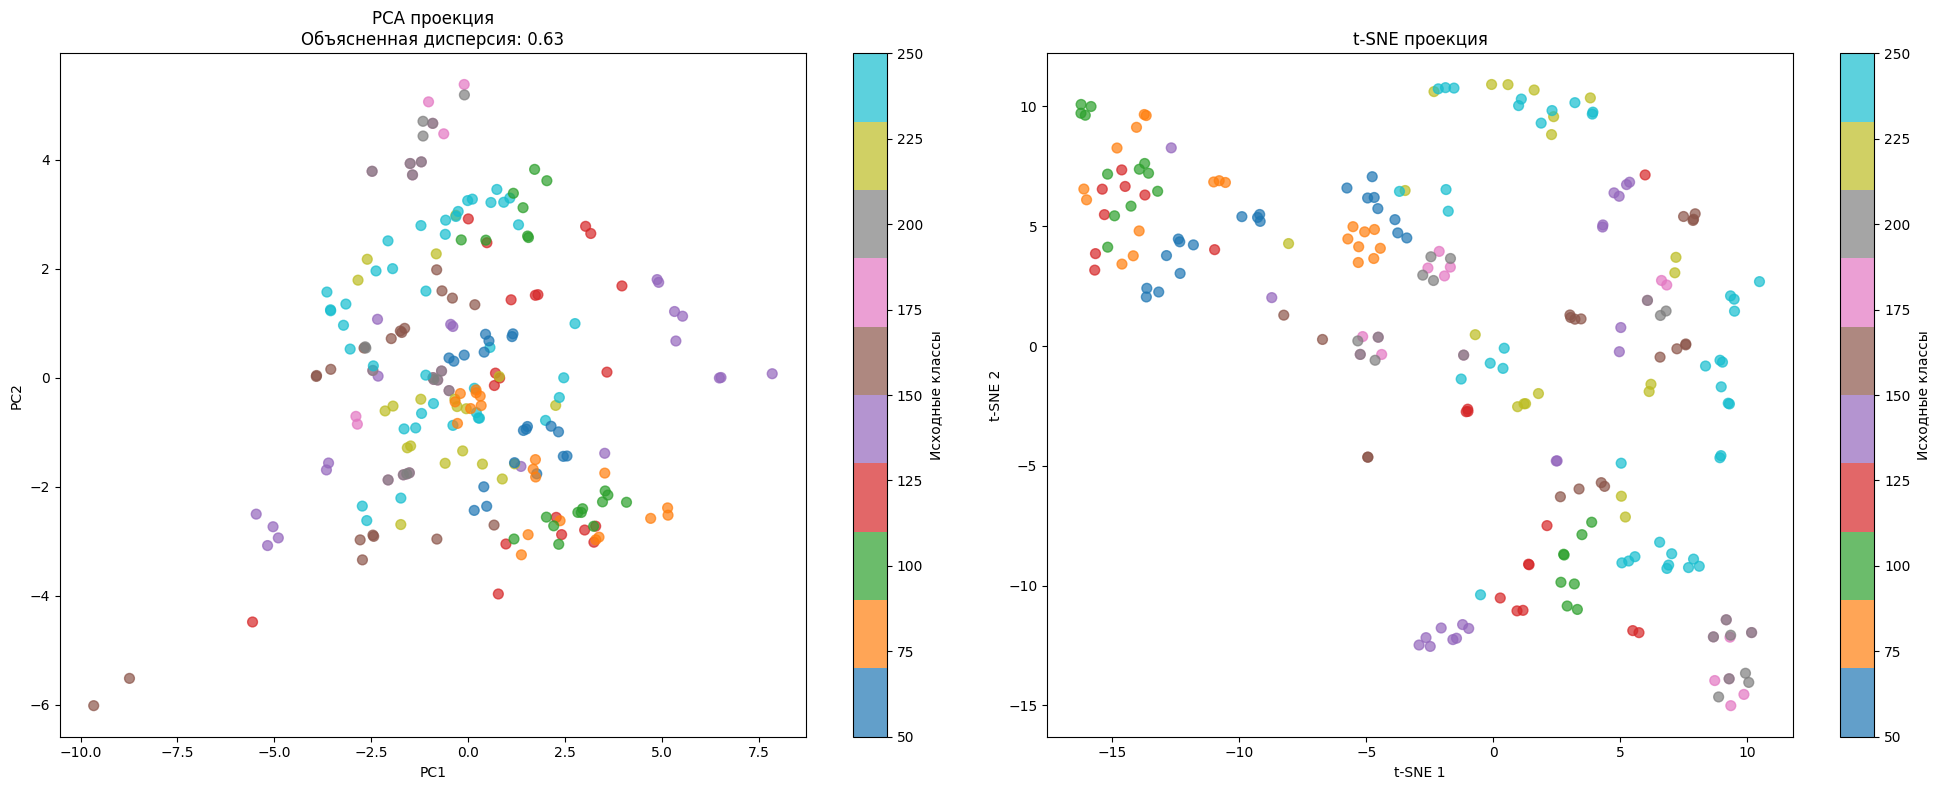

In [46]:
# 1. ВИЗУАЛИЗАЦИЯ В 2D ПЛОСКОСТЬ
print("1. ВИЗУАЛИЗАЦИЯ В 2D ПЛОСКОСТЬ")
print("=" * 50)

# Стандартизация
scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors)

# Создаем список имен объектов
object_names = []
object_classes = []
for class_name, image_paths in labels.items():
    for path in image_paths:
        filename = os.path.basename(path)
        object_names.append(f"{class_name}_{filename}")
        object_classes.append(class_name)

# PCA проекция
print("Вычисляем PSA...")
pca = PCA(n_components=2, random_state=42)
vectors_pca = pca.fit_transform(vectors_scaled)
print(f"PCA: Объясненная дисперсия = {sum(pca.explained_variance_ratio_):.3f}")

# t-SNE проекция  
print("Вычисляем t-SNE...")
tsne = TSNE(n_components=2, random_state=42, verbose=0)
vectors_tsne = tsne.fit_transform(vectors_scaled)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA
scatter1 = ax1.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=targets, cmap='tab10', alpha=0.7, s=50)
ax1.set_title(f'PCA проекция\nОбъясненная дисперсия: {sum(pca.explained_variance_ratio_):.2f}')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
plt.colorbar(scatter1, ax=ax1, label='Исходные классы')

# t-SNE
scatter2 = ax2.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], c=targets, cmap='tab10', alpha=0.7, s=50)
ax2.set_title('t-SNE проекция')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
plt.colorbar(scatter2, ax=ax2, label='Исходные классы')

plt.tight_layout()
plt.show()

# Сохраняем проекции для кластеризации
projections = {
    'PCA': vectors_pca,
    't-SNE': vectors_tsne
}

In [47]:
# 2. КЛАСТЕРИЗАЦИЯ
print("\n2. КЛАСТЕРИЗАЦИЯ МЕТОДАМИ")
print("=" * 50)

# Будем использовать PCA проекцию для кластеризации (она стабильнее)
X_for_clustering = vectors_pca

results = {}

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_for_clustering)
kmeans_score = silhouette_score(X_for_clustering, kmeans_labels)
results['KMeans'] = {
    'labels': kmeans_labels, 
    'score': kmeans_score,
    'centers': kmeans.cluster_centers_
}

bandwidth = estimate_bandwidth(X_for_clustering, quantile=0.2)
meanshift = MeanShift(bandwidth=bandwidth, n_jobs=-1)
meanshift_labels = meanshift.fit_predict(X_for_clustering)
meanshift_score = silhouette_score(X_for_clustering, meanshift_labels) if len(np.unique(meanshift_labels)) > 1 else -1
results['MeanShift'] = {
    'labels': meanshift_labels, 
    'score': meanshift_score,
    'centers': meanshift.cluster_centers_
}

gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_for_clustering)
gmm_score = silhouette_score(X_for_clustering, gmm_labels)
results['GMM'] = {
    'labels': gmm_labels, 
    'score': gmm_score,
    'centers': gmm.means_
}

agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_for_clustering)
agglo_score = silhouette_score(X_for_clustering, agglo_labels)
results['Agglomerative'] = {
    'labels': agglo_labels, 
    'score': agglo_score,
    'centers': None
}

print("Все методы кластеризации готовы!")


2. КЛАСТЕРИЗАЦИЯ МЕТОДАМИ
Все методы кластеризации готовы!


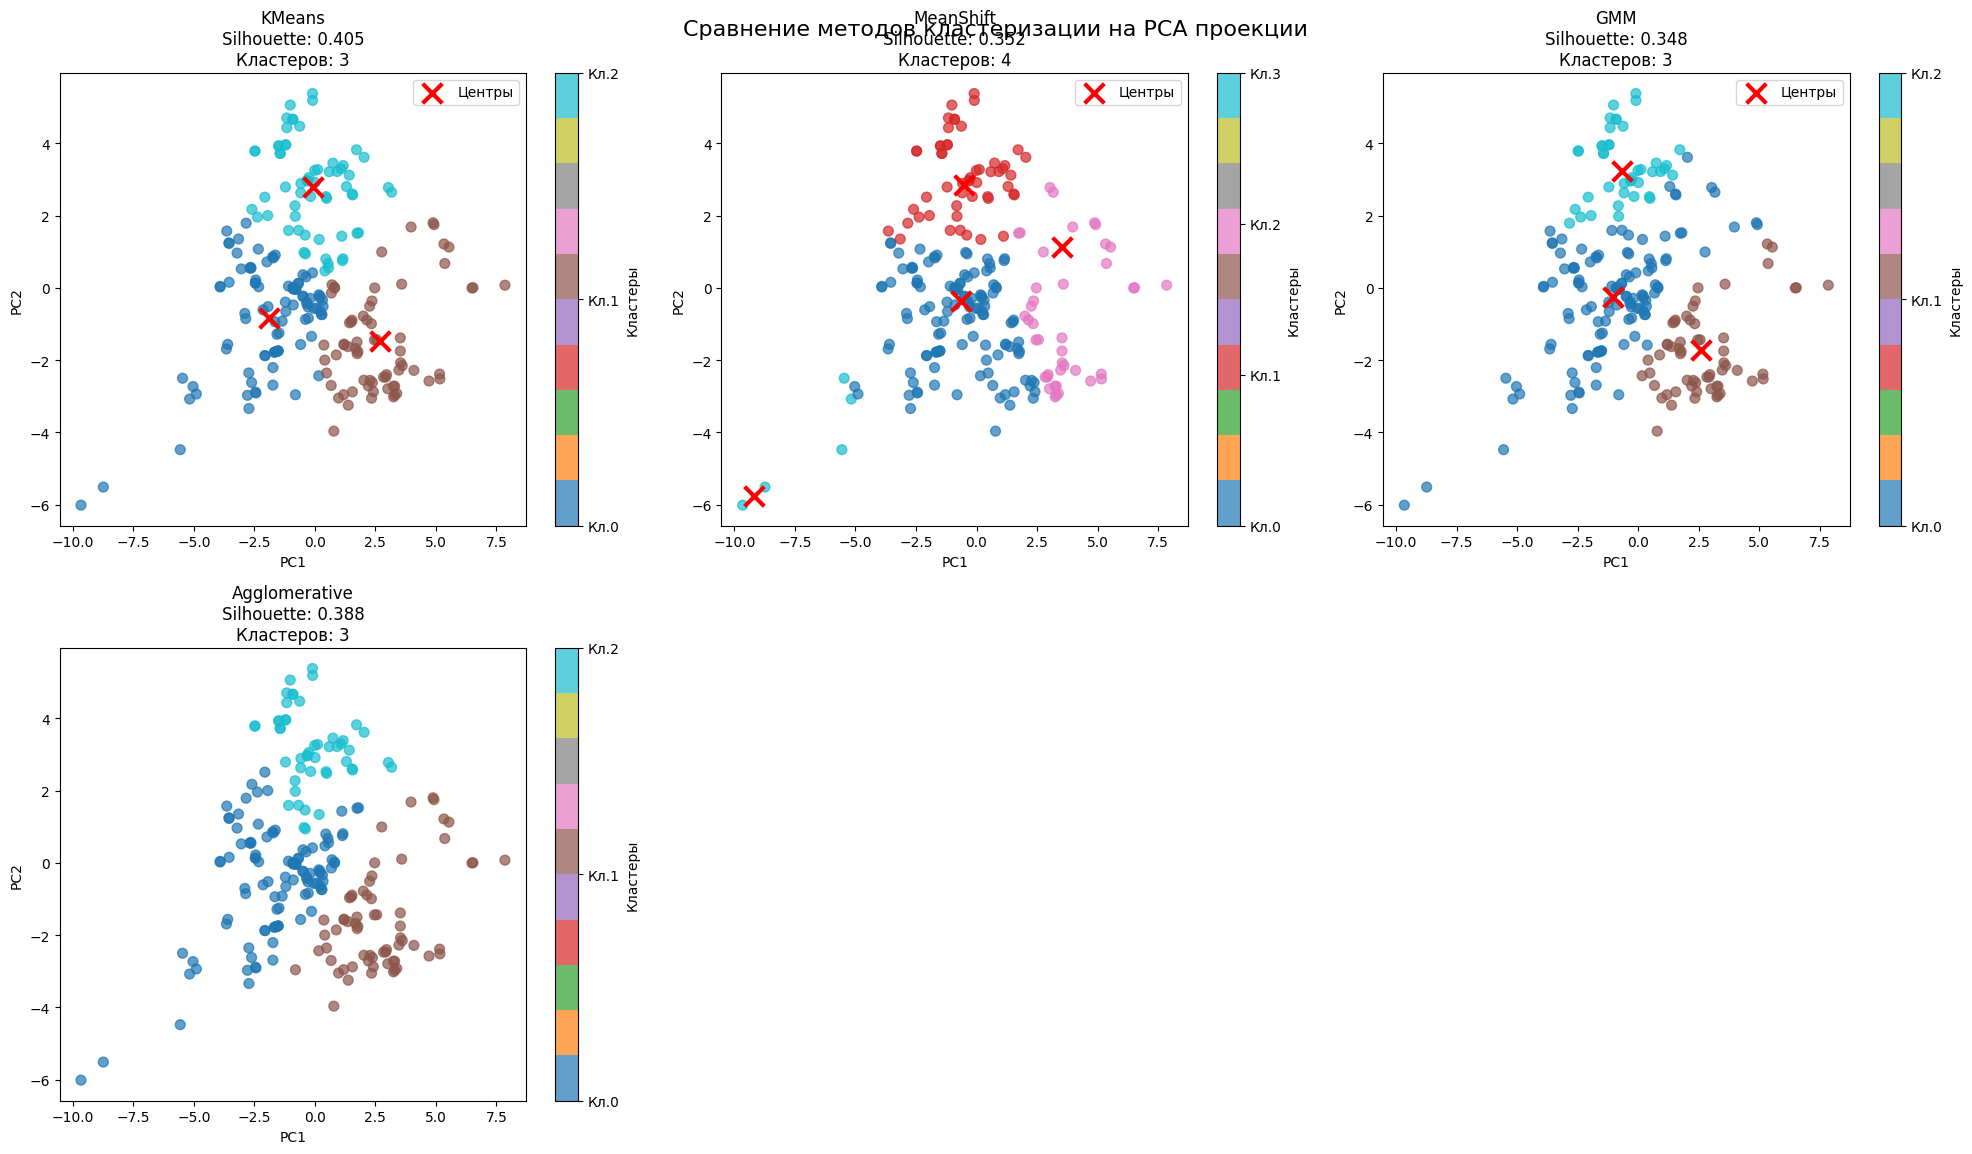

In [48]:
# 3. ВИЗУАЛИЗАЦИЯ КЛАСТЕРИЗАЦИИ С ДИНАМИЧЕСКОЙ ЦВЕТОВОЙ ШКАЛОЙ

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

methods = list(results.keys())
for idx, method_name in enumerate(methods):
    if idx >= 6:  # Максимум 6 графиков
        break
        
    result = results[method_name]
    labels = result['labels']
    
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters <= 10:
        cmap = plt.cm.tab10
    elif n_clusters <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = plt.cm.viridis
    
    scatter = axes[idx].scatter(vectors_pca[:, 0], vectors_pca[:, 1], 
                              c=labels, cmap=cmap, alpha=0.7, s=50, 
                              vmin=min(unique_labels), vmax=max(unique_labels))

    if result['centers'] is not None:
        axes[idx].scatter(result['centers'][:, 0], result['centers'][:, 1], 
                         marker='x', s=200, linewidth=3, color='red', label='Центры')
        axes[idx].legend()

    cbar = plt.colorbar(scatter, ax=axes[idx])
    
    if n_clusters <= 20:  # Если кластеров немного, показываем все метки
        cbar.set_ticks(unique_labels)
        cbar.set_ticklabels([f'Кл.{int(l)}' if l != -1 else 'Выбросы' for l in unique_labels])
    else: 
        tick_indices = np.arange(0, len(unique_labels), max(1, len(unique_labels)//10))
        cbar.set_ticks(unique_labels[tick_indices])
        cbar.set_ticklabels([f'Кл.{int(l)}' for l in unique_labels[tick_indices]])
    
    cbar.set_label('Кластеры')
    
    axes[idx].set_title(f'{method_name}\nSilhouette: {result["score"]:.3f}\nКластеров: {n_clusters}')
    axes[idx].set_xlabel('PC1')
    axes[idx].set_ylabel('PC2')

for idx in range(len(methods), 6):
    axes[idx].set_visible(False)

plt.suptitle('Сравнение методов кластеризации на PCA проекции', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

In [49]:
print("\n4. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 60)
feature_names = [
    'brightness_mean', 'brightness_std', 'brightness_skew', 'brightness_kurtosis', 'brightness_median',
    'contrast_mean', 'contrast_std', 'energy_mean', 'energy_std', 'homogeneity_mean', 'homogeneity_std',
    'correlation_mean', 'correlation_std', 'dissimilarity_mean', 'dissimilarity_std', 'ASM_mean', 'ASM_std',
    'entropy'
]
detailed_data = []
for i in range(len(vectors)):
    row = {
        'Объект_ID': i,
        'Имя_файла': object_names[i],
        'Исходный_класс': object_classes[i],
    }
    
    for method_name, result in results.items():
        row[f'{method_name}_кластер'] = result['labels'][i]
    
    detailed_data.append(row)

detailed_df = pd.DataFrame(detailed_data)

comparison_data = []
for method_name, result in results.items():
    labels = result['labels']
    n_clusters = len(np.unique(labels))
    n_noise = np.sum(labels == -1) if -1 in labels else 0
    
    comparison_data.append({
        'Метод': method_name,
        'Кластеров': n_clusters,
        'Выбросов': n_noise,
        'Silhouette': f"{result['score']:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Анализ лучшего метода
best_method = max(results.items(), key=lambda x: x[1]['score'])
print(f"\nЛУЧШИЙ МЕТОД: {best_method[0]} (Silhouette: {best_method[1]['score']:.3f})")

# Анализ распределения по кластерам для лучшего метода
print(f"\nРАСПРЕДЕЛЕНИЕ ДЛЯ {best_method[0]}:")
print("=" * 40)

best_labels = best_method[1]['labels']
unique_clusters = np.unique(best_labels)

for cluster_id in unique_clusters:
    cluster_mask = best_labels == cluster_id
    cluster_size = np.sum(cluster_mask)
    cluster_classes = [object_classes[i] for i in range(len(best_labels)) if best_labels[i] == cluster_id]
    
    class_distribution = Counter(cluster_classes)
    print(f"КЛАСТЕР {cluster_id}: {cluster_size} объектов")
    print(f" Распределение по исходным классам:")
    for class_name, count in class_distribution.most_common():
        percentage = (count / cluster_size) * 100
        print(f"{class_name}: {count} ({percentage:.1f}%)")

full_table_filename = 'all_objects_complete_table.csv'
full_data = []
for i in range(len(vectors)):
    row = {
        'Объект_ID': i,
        'Имя_файла': object_names[i],
        'Исходный_класс': object_classes[i],
    }

    for j, feature in enumerate(feature_names):
        row[feature] = vectors[i, j]
    
    for method_name, result in results.items():
        row[f'{method_name}_кластер'] = result['labels'][i]
    
    full_data.append(row)

full_df = pd.DataFrame(full_data)
full_df.to_csv(full_table_filename, index=False, encoding='utf-8')
print(f"Сохранена полная таблица всех объектов: {full_table_filename}")

# Сохраняем объекты каждого кластера в отдельные файлы
for cluster_id in unique_clusters:
    cluster_indices = [i for i, label in enumerate(best_labels) if label == cluster_id]
    cluster_objects = detailed_df.iloc[cluster_indices].copy()
    for i, feature in enumerate(feature_names):
        if i < vectors.shape[1]:
            cluster_objects[feature] = vectors[cluster_indices, i]
    
    cluster_filename = f'cluster_{best_method[0]}_{cluster_id}_all_objects.xlsx'
    # cluster_filename = f'cluster_{best_method[0]}_{cluster_id}_all_objects.csv'
    # cluster_objects.to_csv(cluster_filename, index=False, encoding='utf-8')
    cluster_objects.to_excel(cluster_filename, index=False)
    print(f"Сохранены все объекты кластера {cluster_id}: {cluster_filename}")

print(f"\nСОХРАНЕНО:")
print(f"Для каждого кластера: cluster_[метод]_[номер]_all_objects.csv")
print(f"Полная таблица: all_objects_complete_table.csv")


4. ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
        Метод  Кластеров  Выбросов Silhouette
       KMeans          3         0      0.405
    MeanShift          4         0      0.352
          GMM          3         0      0.348
Agglomerative          3         0      0.388

ЛУЧШИЙ МЕТОД: KMeans (Silhouette: 0.405)

РАСПРЕДЕЛЕНИЕ ДЛЯ KMeans:
КЛАСТЕР 0: 92 объектов
 Распределение по исходным классам:
150: 15 (16.3%)
170: 12 (13.0%)
190: 12 (13.0%)
210: 12 (13.0%)
230: 10 (10.9%)
250: 10 (10.9%)
130: 8 (8.7%)
70: 8 (8.7%)
50: 4 (4.3%)
110: 1 (1.1%)
КЛАСТЕР 1: 67 объектов
 Распределение по исходным классам:
110: 12 (17.9%)
70: 12 (17.9%)
90: 12 (17.9%)
50: 11 (16.4%)
130: 10 (14.9%)
210: 5 (7.5%)
230: 2 (3.0%)
250: 2 (3.0%)
150: 1 (1.5%)
КЛАСТЕР 2: 62 объектов
 Распределение по исходным классам:
250: 9 (14.5%)
170: 8 (12.9%)
190: 8 (12.9%)
230: 8 (12.9%)
90: 8 (12.9%)
110: 7 (11.3%)
50: 5 (8.1%)
150: 4 (6.5%)
210: 3 (4.8%)
130: 2 (3.2%)
Сохранена полная таблица всех объектов: all_objects_complete_tab

Подробная таблица сохранена в 'clustering_analysis.csv'
Сравнение методов сохранено в 'clustering_methods_comparison.csv'
Визуализация сохранена в 'best_clustering.png'

АНАЛИЗ ЗАВЕРШЕН!
Всего обработано: 221 объектов из 11 классов
Лучший метод кластеризации: KMeans
Качество кластеризации: 0.405


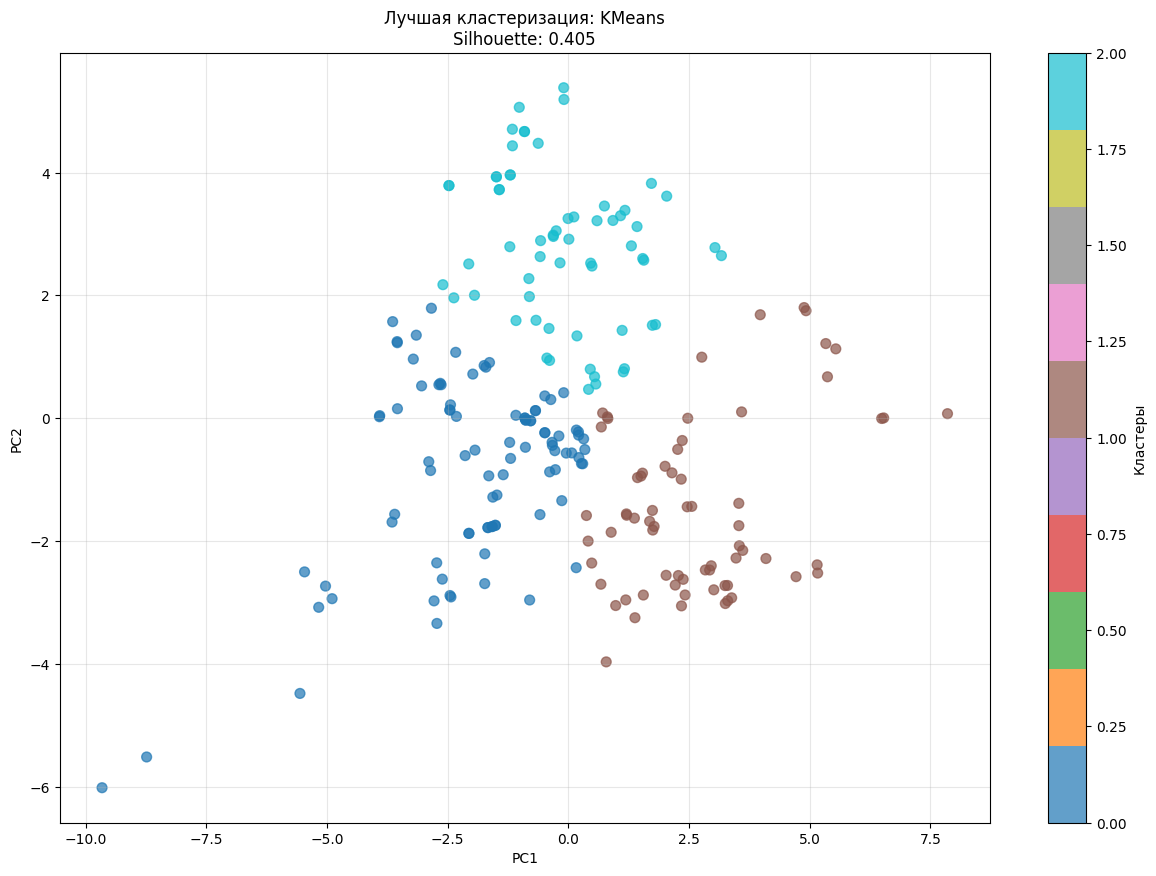

In [50]:
detailed_df.to_csv('clustering_analysis.csv', index=False, encoding='utf-8')
print("Подробная таблица сохранена в 'clustering_analysis.csv'")

# Сохраняем статистику по методам
comparison_df.to_csv('clustering_methods_comparison.csv', index=False, encoding='utf-8')
print("Сравнение методов сохранено в 'clustering_methods_comparison.csv'")

# Сохраняем визуализации
plt.figure(figsize=(15, 10))
plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=best_labels, cmap='tab10', alpha=0.7, s=50)
plt.title(f'Лучшая кластеризация: {best_method[0]}\nSilhouette: {best_method[1]["score"]:.3f}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Кластеры')
plt.grid(True, alpha=0.3)
plt.savefig('best_clustering.png', dpi=300, bbox_inches='tight')
print("Визуализация сохранена в 'best_clustering.png'")

print(f"\nАНАЛИЗ ЗАВЕРШЕН!")
print(f"Всего обработано: {len(vectors)} объектов из {len(gray_images_dict)} классов")
print(f"Лучший метод кластеризации: {best_method[0]}")
print(f"Качество кластеризации: {best_method[1]['score']:.3f}")

In [51]:
pca_components = pca.components_

# ANOVA тест для каждого признака
anova_results = []
for i, feature_name in enumerate(feature_names):
    # Собираем данные по кластерам
    cluster_data = []
    for cluster_id in unique_clusters:
        cluster_data.append(vectors[best_labels == cluster_id, i])
    
    # ANOVA тест
    f_stat, p_value = f_oneway(*cluster_data)
    anova_results.append((feature_name, f_stat, p_value))

# Сортируем по F-статистике (чем выше, тем больше различия)
anova_sorted = sorted(anova_results, key=lambda x: x[1], reverse=True)[:10]


ВЫДЕЛЕНИЕ САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК
ТОП-10 САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК:
0.972 | correlation_mean          | F: 144.91 | PC1: 0.298 | PC2: 0.195
0.961 | brightness_std            | F: 146.77 | PC1: 0.082 | PC2: 0.389
0.920 | brightness_mean           | F: 150.05 | PC1: 0.016 | PC2: 0.386
0.790 | brightness_kurtosis       | F: 104.64 | PC1: 0.108 | PC2: 0.359
0.787 | homogeneity_mean          | F: 127.70 | PC1: 0.341 | PC2: 0.007
0.748 | dissimilarity_mean        | F: 109.39 | PC1: 0.357 | PC2: 0.033
0.679 | entropy                   | F:  92.15 | PC1: 0.002 | PC2: 0.389
0.640 | energy_mean               | F:  59.94 | PC1: 0.306 | PC2: 0.197
0.586 | homogeneity_std           | F:  64.07 | PC1: 0.225 | PC2: 0.190
0.586 | ASM_std                   | F:  63.90 | PC1: 0.321 | PC2: 0.095


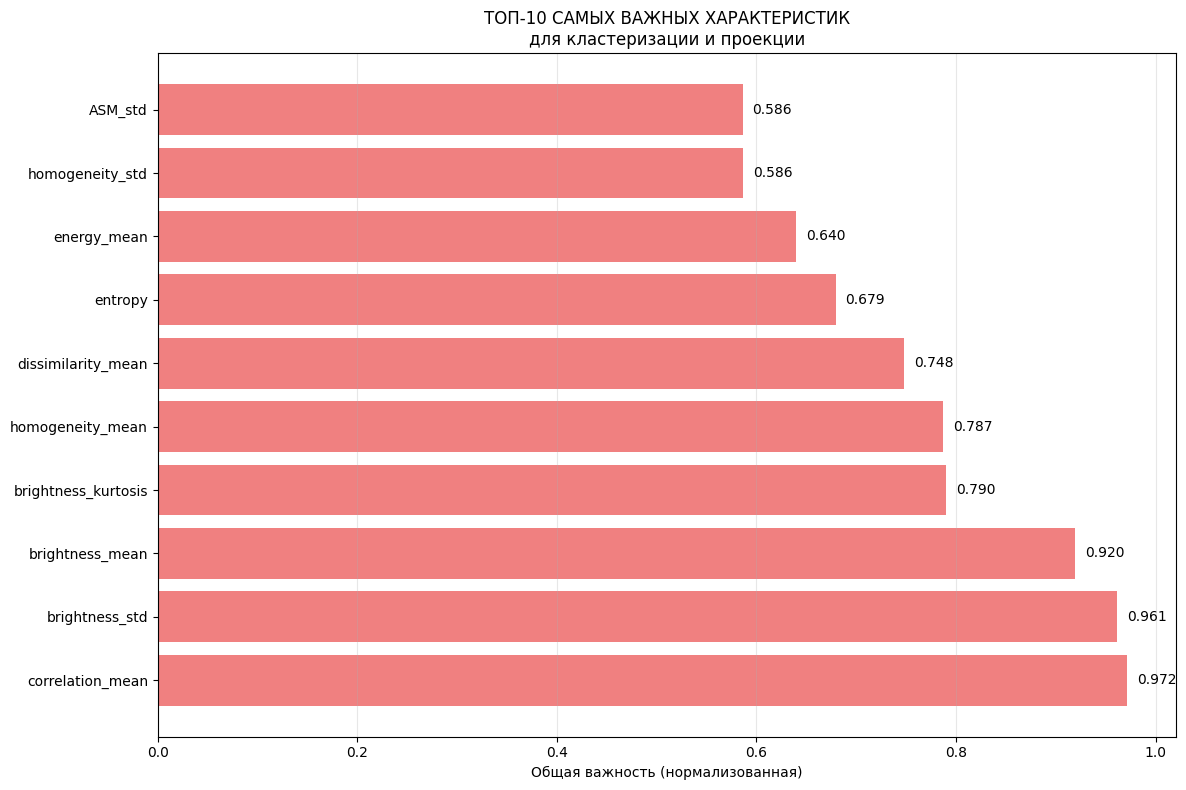


РАСПРЕДЕЛЕНИЕ ВАЖНЫХ ХАРАКТЕРИСТИК ПО ТИПАМ:
Яркостные характеристики: 3
   - brightness_std
   - brightness_mean
   - brightness_kurtosis

Текстуры (GLCM): 2
   - correlation_mean
   - homogeneity_mean

Другие характеристики: 0

ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-3 ХАРАКТЕРИСТИК:

#1: correlation_mean
Общая важность: 0.972
Влияние на PC1: 0.298
Влияние на PC2: 0.195
Различия между кластерами (F): 144.91
Средние значения по кластерам:
      Кластер 0: 0.990 ± 0.006
      Кластер 1: 0.969 ± 0.013
      Кластер 2: 0.993 ± 0.005

#2: brightness_std
Общая важность: 0.961
Влияние на PC1: 0.082
Влияние на PC2: 0.389
Различия между кластерами (F): 146.77
Средние значения по кластерам:
      Кластер 0: 0.172 ± 0.041
      Кластер 1: 0.144 ± 0.032
      Кластер 2: 0.259 ± 0.044

#3: brightness_mean
Общая важность: 0.920
Влияние на PC1: 0.016
Влияние на PC2: 0.386
Различия между кластерами (F): 150.05
Средние значения по кластерам:
      Кластер 0: 0.684 ± 0.049
      Кластер 1: 0.671 ± 0.024
      Кластер 2

In [52]:
# ВЫДЕЛЕНИЕ САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК
print("\nВЫДЕЛЕНИЕ САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК")
print("=" * 60)

# Собираем все метрики важности
importance_metrics = []

for i, feature_name in enumerate(feature_names):
    metrics = {
        'Признак': feature_name,
        'Важность_PC1': abs(pca_components[0, i]),
        'Важность_PC2': abs(pca_components[1, i]),
        'Суммарная_важность_PCA': abs(pca_components[0, i]) + abs(pca_components[1, i])
    }
    
    # Добавляем ANOVA если есть кластеры
    if len(unique_clusters) > 1:
        anova_result = next((item for item in anova_results if item[0] == feature_name), None)
        if anova_result:
            metrics['F_статистика'] = anova_result[1]
            metrics['ANOVA_значимость'] = anova_result[2]
    
    importance_metrics.append(metrics)

importance_df = pd.DataFrame(importance_metrics)

# Вычисляем общий скоринг важности
if 'F_статистика' in importance_df.columns:
    # Нормализуем метрики
    importance_df['Норм_PCA'] = importance_df['Суммарная_важность_PCA'] / importance_df['Суммарная_важность_PCA'].max()
    importance_df['Норм_ANOVA'] = importance_df['F_статистика'] / importance_df['F_статистика'].max()
    
    # Общий скоринг (взвешенный)
    importance_df['Общий_скор'] = 0.6 * importance_df['Норм_ANOVA'] + 0.4 * importance_df['Норм_PCA']
else:
    importance_df['Общий_скор'] = importance_df['Суммарная_важность_PCA'] / importance_df['Суммарная_важность_PCA'].max()

# Сортируем по важности
importance_df_sorted = importance_df.sort_values('Общий_скор', ascending=False)

print("ТОП-10 САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК:")
print("=" * 50)
top_features = importance_df_sorted.head(10)[['Признак', 'Общий_скор', 'Важность_PC1', 'Важность_PC2'] + 
                                           (['F_статистика'] if 'F_статистика' in importance_df.columns else [])]

for idx, row in top_features.iterrows():
    print(f"{row['Общий_скор']:.3f} | {row['Признак']:25} | ", end="")
    if 'F_статистика' in row:
        print(f"F: {row['F_статистика']:6.2f} | ", end="")
    print(f"PC1: {row['Важность_PC1']:.3f} | PC2: {row['Важность_PC2']:.3f}")

# Визуализация топ-характеристик
plt.figure(figsize=(12, 8))
top_10 = importance_df_sorted.head(10)

bars = plt.barh(top_10['Признак'], top_10['Общий_скор'], color='lightcoral')
plt.xlabel('Общая важность (нормализованная)')
plt.title('ТОП-10 САМЫХ ВАЖНЫХ ХАРАКТЕРИСТИК\nдля кластеризации и проекции')
plt.grid(True, alpha=0.3, axis='x')

# Добавляем значения на бары
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Анализ по типам характеристик
print(f"\nРАСПРЕДЕЛЕНИЕ ВАЖНЫХ ХАРАКТЕРИСТИК ПО ТИПАМ:")
print("=" * 50)

top_5_features = importance_df_sorted.head(5)['Признак'].tolist()

brightness_features = [f for f in top_5_features if 'brightness' in f]
glcm_features = [f for f in top_5_features if any(x in f for x in ['contrast', 'energy', 'homogeneity', 'correlation', 'dissimilarity', 'ASM'])]
other_features = [f for f in top_5_features if f not in brightness_features + glcm_features]

print(f"Яркостные характеристики: {len(brightness_features)}")
for feat in brightness_features:
    print(f"   - {feat}")

print(f"\nТекстуры (GLCM): {len(glcm_features)}")
for feat in glcm_features:
    print(f"   - {feat}")

print(f"\nДругие характеристики: {len(other_features)}")
for feat in other_features:
    print(f"   - {feat}")

# Детальный анализ топ-3 характеристик
print(f"\nДЕТАЛЬНЫЙ АНАЛИЗ ТОП-3 ХАРАКТЕРИСТИК:")
print("=" * 50)

top_3_features = importance_df_sorted.head(3)['Признак'].tolist()

for i, feature in enumerate(top_3_features, 1):
    feature_idx = feature_names.index(feature)
    
    print(f"\n#{i}: {feature}")
    print(f"Общая важность: {importance_df_sorted.iloc[i-1]['Общий_скор']:.3f}")
    print(f"Влияние на PC1: {importance_df_sorted.iloc[i-1]['Важность_PC1']:.3f}")
    print(f"Влияние на PC2: {importance_df_sorted.iloc[i-1]['Важность_PC2']:.3f}")
    
    if 'F_статистика' in importance_df_sorted.columns:
        print(f"Различия между кластерами (F): {importance_df_sorted.iloc[i-1]['F_статистика']:.2f}")
    
    # Анализ значений по кластерам
    if len(unique_clusters) > 1:
        print(f"Средние значения по кластерам:")
        for cluster_id in unique_clusters:
            cluster_values = vectors[best_labels == cluster_id, feature_idx]
            mean_val = np.mean(cluster_values)
            std_val = np.std(cluster_values)
            print(f"      Кластер {cluster_id}: {mean_val:.3f} ± {std_val:.3f}")

top_features_analysis = importance_df_sorted.head(10).copy()
top_features_analysis = top_features_analysis.round(4)

top_features_analysis.to_csv('top_crucial_features.csv', index=False, encoding='utf-8')
print("Топ-10 важных характеристик сохранен в 'top_crucial_features.csv'")

print(f"\nКРАТКИЙ ОТЧЕТ ПО ВАЖНЫМ ХАРАКТЕРИСТИКАМ:")
print("=" * 50)
print(f"САМЫЕ ВАЖНЫЕ ХАРАКТЕРИСТИКИ ДЛЯ КЛАСТЕРИЗАЦИИ:")
for i, feature in enumerate(top_3_features, 1):
    print(f"   {i}. {feature}")

print(f"\nВЫВОДЫ:")
print(f"Всего проанализировано: {len(feature_names)} характеристик")
print(f"Ключевых характеристик выделено: {len(top_3_features)}")
print(f"Тип самых важных характеристик: {', '.join([f.split('_')[0] for f in top_3_features])}")

if brightness_features:
    print(f"Яркость играет важную роль: {len(brightness_features)} из топ-5")
if glcm_features:
    print(f"Текстуры (GLCM) значимы: {len(glcm_features)} из топ-5")

print(f"\nАНАЛИЗ ЗАВЕРШЕН! Ты теперь знаешь какие характеристики действительно важны!")